In [6]:
import pandas as pd

from plotnine import ggplot, aes, geom_line, labs, theme_classic

import os

# Kaggle définit automatiquement la variable d'environnement KAGGLE_URL_BASE
ON_KAGGLE = "KAGGLE_URL_BASE" in os.environ

if ON_KAGGLE:
    DATA_PATH = "/kaggle/input/hull-tactical-market-prediction/"
else:
    DATA_PATH = "../data/raw/"



df_train = pd.read_csv(os.path.join(DATA_PATH, "train.csv")).sort_values("date_id")
df_test = pd.read_csv(os.path.join(DATA_PATH, "test.csv")).sort_values("date_id")



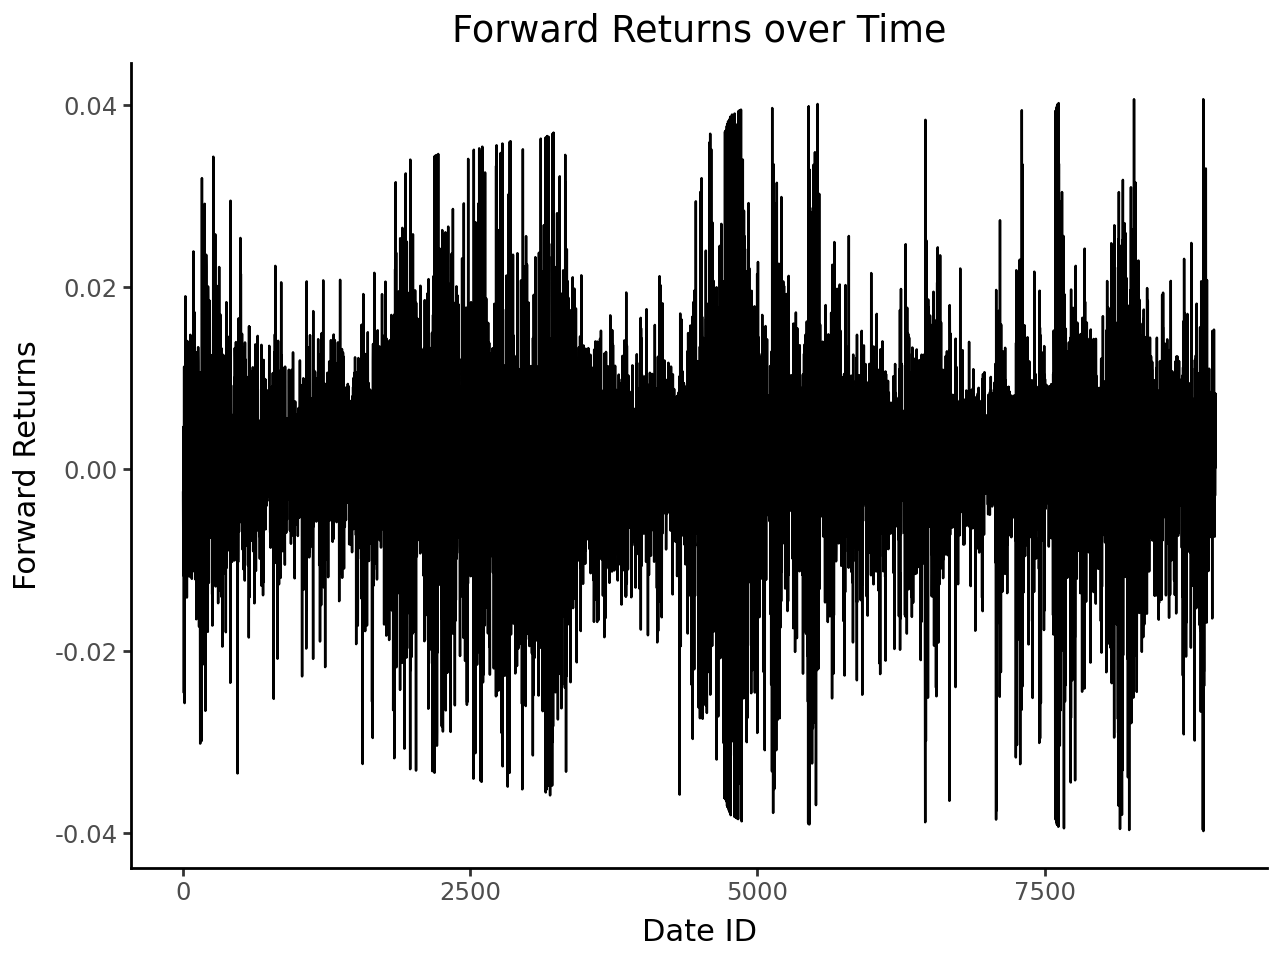

In [5]:
plot = (
    ggplot(train, aes(x="date_id", y="forward_returns"))
    + geom_line()
    + labs(
        title="Forward Returns over Time",
        x="Date ID",
        y="Forward Returns"
    )
    + theme_classic()
)

plot


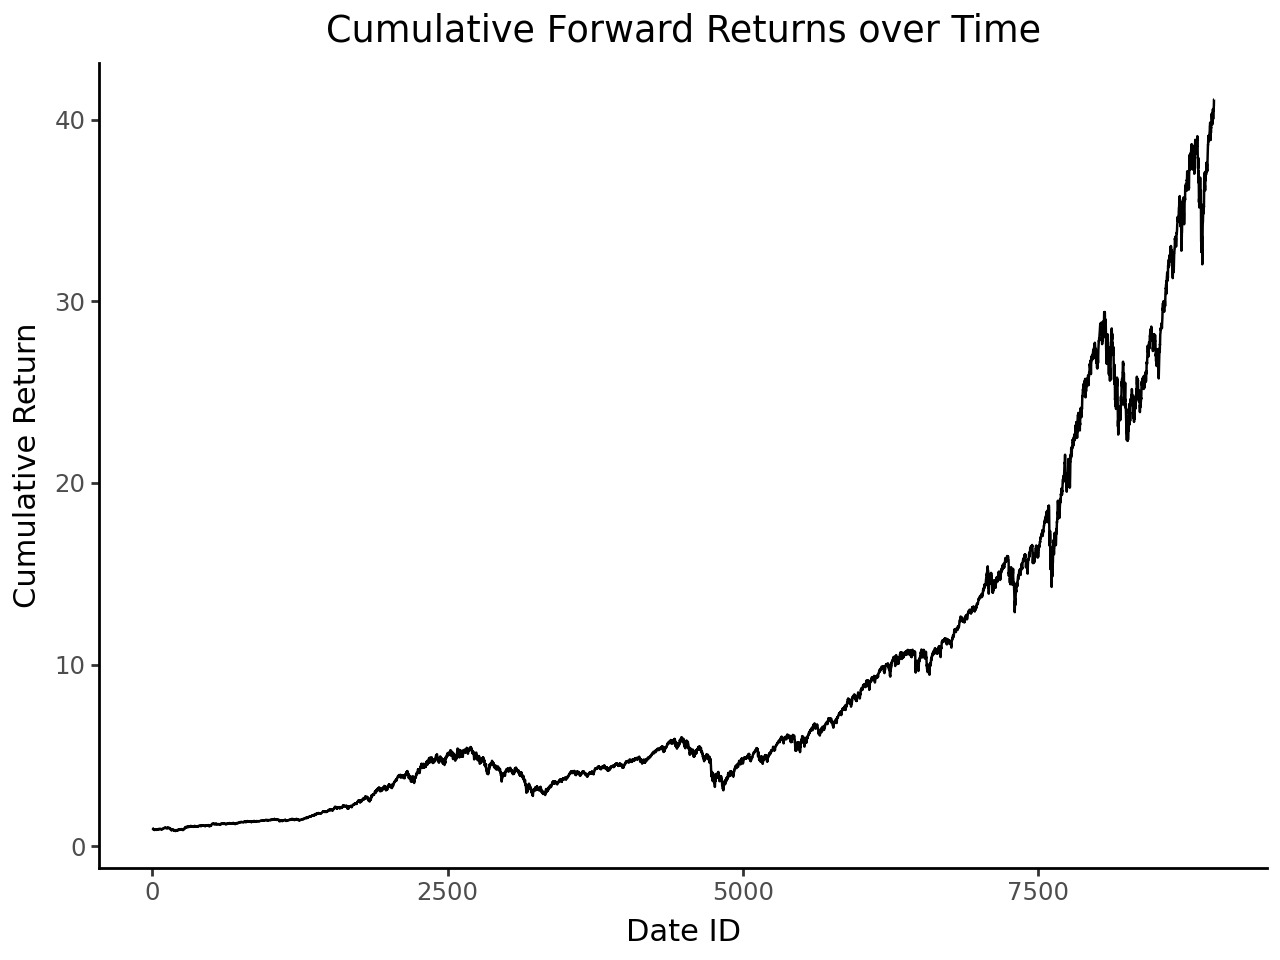

In [11]:
df_train["cumulative_return"] = (1 + df_train["forward_returns"]).cumprod()

plot = (
    ggplot(df_train, aes(x="date_id", y="cumulative_return"))
    + geom_line()
    + labs(
        title="Cumulative Forward Returns over Time",
        x="Date ID",
        y="Cumulative Return"
    )
    + theme_classic()
)

plot